In [1]:
import tensorflow as tf
import scipy
import matplotlib.pyplot as plt
import os
from keras.layers import Conv2D,Rescaling,RandomFlip,RandomRotation,Dense,Flatten,MaxPooling2D,InputLayer,Dropout,RandomZoom,RandomBrightness,RandomTranslation,LeakyReLU,Conv2DTranspose,BatchNormalization,Reshape,Embedding,Concatenate,Input
from keras.losses import SparseCategoricalCrossentropy,BinaryCrossentropy
from keras.utils import plot_model
from keras import Sequential
from keras.optimizers import Adam,SGD,RMSprop
from pathlib import Path
import numpy as np
import copy
from random import randint
import keras
import time
import math

tf.config.list_physical_devices()

2024-09-30 20:17:09.832723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 20:17:09.932889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 20:17:09.933583: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 20:17:10.105022: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-30 20:17:11.447140: W tensorflow/compiler/tf

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
rescale = lambda x,y: ((x/255.0) ,y)
preprocess = lambda x,y: ((x-0.5)/0.5 ,y)
display_model = lambda x,y: plot_model(x,show_shapes=True,show_layer_names=True,to_file=f'{y}.png')

In [17]:
no_of_class = 102
IMG_SIZE = (100,100)
BATCH = 16

train = tf.keras.utils.image_dataset_from_directory('../102_flowers_dataset/train/',image_size=IMG_SIZE,shuffle=True,batch_size=BATCH)

train = train.map(rescale)
train = train.map(preprocess)

Found 6552 files belonging to 102 classes.


2024-09-30 20:19:53.043776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


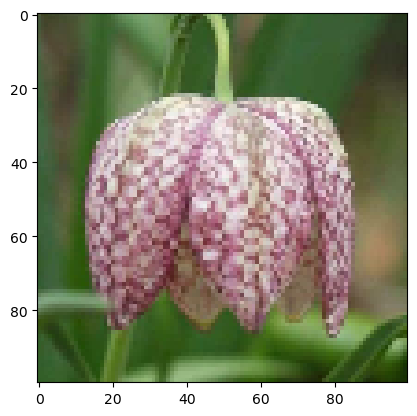

In [18]:
# sampling

for i,j in train.take(1):
    plt.imshow(i[0].numpy()*0.5+0.5)

In [5]:
def discriminator_block(filters:int,name:int,input:keras.Layer) -> keras.Layer:
    
    x = Conv2D(filters=filters, kernel_size=(3,3), strides=2, padding='same', name=f'Convo_{name}')(input)
    x = LeakyReLU(name=f'Leaky_{name}')(x)
    x = Dropout(0.1,name=f'Dropout_{name}')(x)
    
    return x
    
def dense_block(filters:list,input: keras.Layer,start:int) -> keras.Layer:
    
    x = Dense(filters[0],name=f'Dense_{start}',activation='relu')(input)
    
    for i,j in enumerate(filters[1:]):
        x = Dense(j,name=f'Dense_{start+i+1}',activation='relu')(x)
    
    return x
    
def make_discriminator_ac(img: tuple[int],no_of_class:int) -> keras.Model:
    label_input = Input(shape=(1,),name='label_input')
    
    l = Embedding(no_of_class,256,name='label_embedding')(label_input)
    l = Dense(np.prod(img)*3,name='label_dense')(l)
    l = Reshape((img[0], img[1],3),name='label_Reshape')(l)
    
    img_input = Input(shape=(img[0],img[1],3),name='image_input')

    
    merge = Concatenate(name='concatenate')([img_input,l])
    
    x = discriminator_block(16,1,merge)
    x = discriminator_block(32,2,x)
    x = discriminator_block(64,3,x)
    x = discriminator_block(128,4,x)
    x = Flatten(name='flatten')(x)
    
    
    label_based = dense_block([256,128],x,1)
    label_based = Dense(no_of_class,activation='softmax',name='label_predict')(label_based)
    
    real_based = dense_block([128,64,32,16,8],x,3)
    real_based = Dense(1, activation='sigmoid',name='real_predict')(real_based)
    
    discriminator = tf.keras.Model([img_input,label_input],[label_based,real_based],name='AC_Discriminator')
    
    return discriminator


In [19]:
make_discriminator_ac(IMG_SIZE,no_of_class).summary()

Model: "AC_Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_embedding     │ (None, 1, 256)    │     26,112 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_dense (Dense) │ (None, 1, 30000)  │  7,710,000 │ label_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_Reshape       │ (None, 100, 100,  │          0 │ label_dense[0][0] │
│ (Reshape)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100, 100,  │          0 │ image_input[0][0… │
│ (Concatenate)       │ 6)                │            │ label_Reshape[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convo_1 (Conv2D)    │ (None, 50, 50,    │        880 │ concatenate[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_1 (LeakyReLU) │ (None, 50, 50,    │          0 │ Convo_1[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_1 (Dropout) │ (None, 50, 50,    │          0 │ Leaky_1[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convo_2 (Conv2D)    │ (None, 25, 25,    │      4,640 │ Dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_2 (LeakyReLU) │ (None, 25, 25,    │          0 │ Convo_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_2 (Dropout) │ (None, 25, 25,    │          0 │ Leaky_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convo_3 (Conv2D)    │ (None, 13, 13,    │     18,496 │ Dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_3 (LeakyReLU) │ (None, 13, 13,    │          0 │ Convo_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_3 (Dropout) │ (None, 13, 13,    │          0 │ Leaky_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Convo_4 (Conv2D)    │ (None, 7, 7, 128) │     73,856 │ Dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_4 (LeakyReLU) │ (None, 7, 7, 128) │          0 │ Convo_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout_4 (Dropout) │ (None, 7, 7, 128) │          0 │ Leaky_4[0][0]   

 Total params: 10,299,879 (39.29 MB)

 Trainable params: 10,299,879 (39.29 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
#display_model(make_discriminator_ac(IMG_SIZE,no_of_class),'../model_arch/ac_disc')

In [20]:
latent_dim = np.array([10,10,256])
noise_shape = 256

def upsample_block(filters:int,name:int,strides:int,kernel:int,input:keras.Layer) -> keras.Layer:
    
    x = Conv2DTranspose(filters,(kernel,kernel),strides=strides,padding='same', name=f'conv_{name}')(input)
    x = BatchNormalization(name=f'norm_{name}')(x)
    x = LeakyReLU(name=f'leaky_{name}')(x)
    
    return x

def make_generator_ac(no_of_class:int,noise_shape:tuple[int],latent_dim:tuple[int]) -> keras.Model:
    
    label_input = Input(shape=(1,),name='label_input')
    l = Embedding(no_of_class,256,name='label_embedding')(label_input)
    l = Dense(np.cumprod(latent_dim)[-2]*3,name='label_dense')(l)
    l = Reshape(np.append(latent_dim[:-1],[3]),name='label_Reshape')(l)
    
    noise_input = Input(shape=(noise_shape,),name='noise_input')
    n = Dense(np.prod(latent_dim),name='noise_dense')(noise_input)
    n = BatchNormalization(name='norm_noise')(n)
    n = LeakyReLU(name='leaky_noise')(n)
    n = Reshape(latent_dim,name='noise_reshape')(n)
    
    merge = Concatenate(name='concatenate')([n,l])
    
    x = upsample_block(filters=512,name=1,strides=2,kernel=3,input=merge)
    x = upsample_block(filters=256,name=2,strides=1,kernel=2,input=x)
        
    x = upsample_block(filters=128,name=3,strides=5,kernel=6,input=x)
    x = upsample_block(filters=64,name=4,strides=1,kernel=2,input=x)
    
    x = Conv2DTranspose(3,(3,3),strides=1,padding='same', name='final',activation='tanh')(x)
    
    generator = tf.keras.Model([noise_input,label_input],x,name='AC_Generator')
    
    return generator

In [21]:
make_generator_ac(no_of_class,noise_shape,latent_dim).summary()

Model: "AC_Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ noise_input         │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_dense (Dense) │ (None, 25600)     │  6,579,200 │ noise_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_noise          │ (None, 25600)     │    102,400 │ noise_dense[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_embedding     │ (None, 1, 256)    │     26,112 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_noise         │ (None, 25600)     │          0 │ norm_noise[0][0]  │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_dense (Dense) │ (None, 1, 300)    │     77,100 │ label_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_reshape       │ (None, 10, 10,    │          0 │ leaky_noise[0][0] │
│ (Reshape)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_Reshape       │ (None, 10, 10, 3) │          0 │ label_dense[0][0] │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 10,    │          0 │ noise_reshape[0]… │
│ (Concatenate)       │ 259)              │            │ label_Reshape[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1              │ (None, 20, 20,    │  1,193,984 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_1              │ (None, 20, 20,    │      2,048 │ conv_1[0][0]      │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_1 (LeakyReLU) │ (None, 20, 20,    │          0 │ norm_1[0][0]      │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2              │ (None, 20, 20,    │    524,544 │ leaky_1[0][0]     │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_2              │ (None, 20, 20,    │      1,024 │ conv_2[0][0]      │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_2 (LeakyReLU) │ (None, 20, 20,    │          0 │ norm_2[0][0]      │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3              │ (None, 100, 100,  │  1,179,776 │ leaky_2[0][0]     │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 9,721,519 (37.08 MB)

 Trainable params: 9,668,399 (36.88 MB)

 Non-trainable params: 53,120 (207.50 KB)

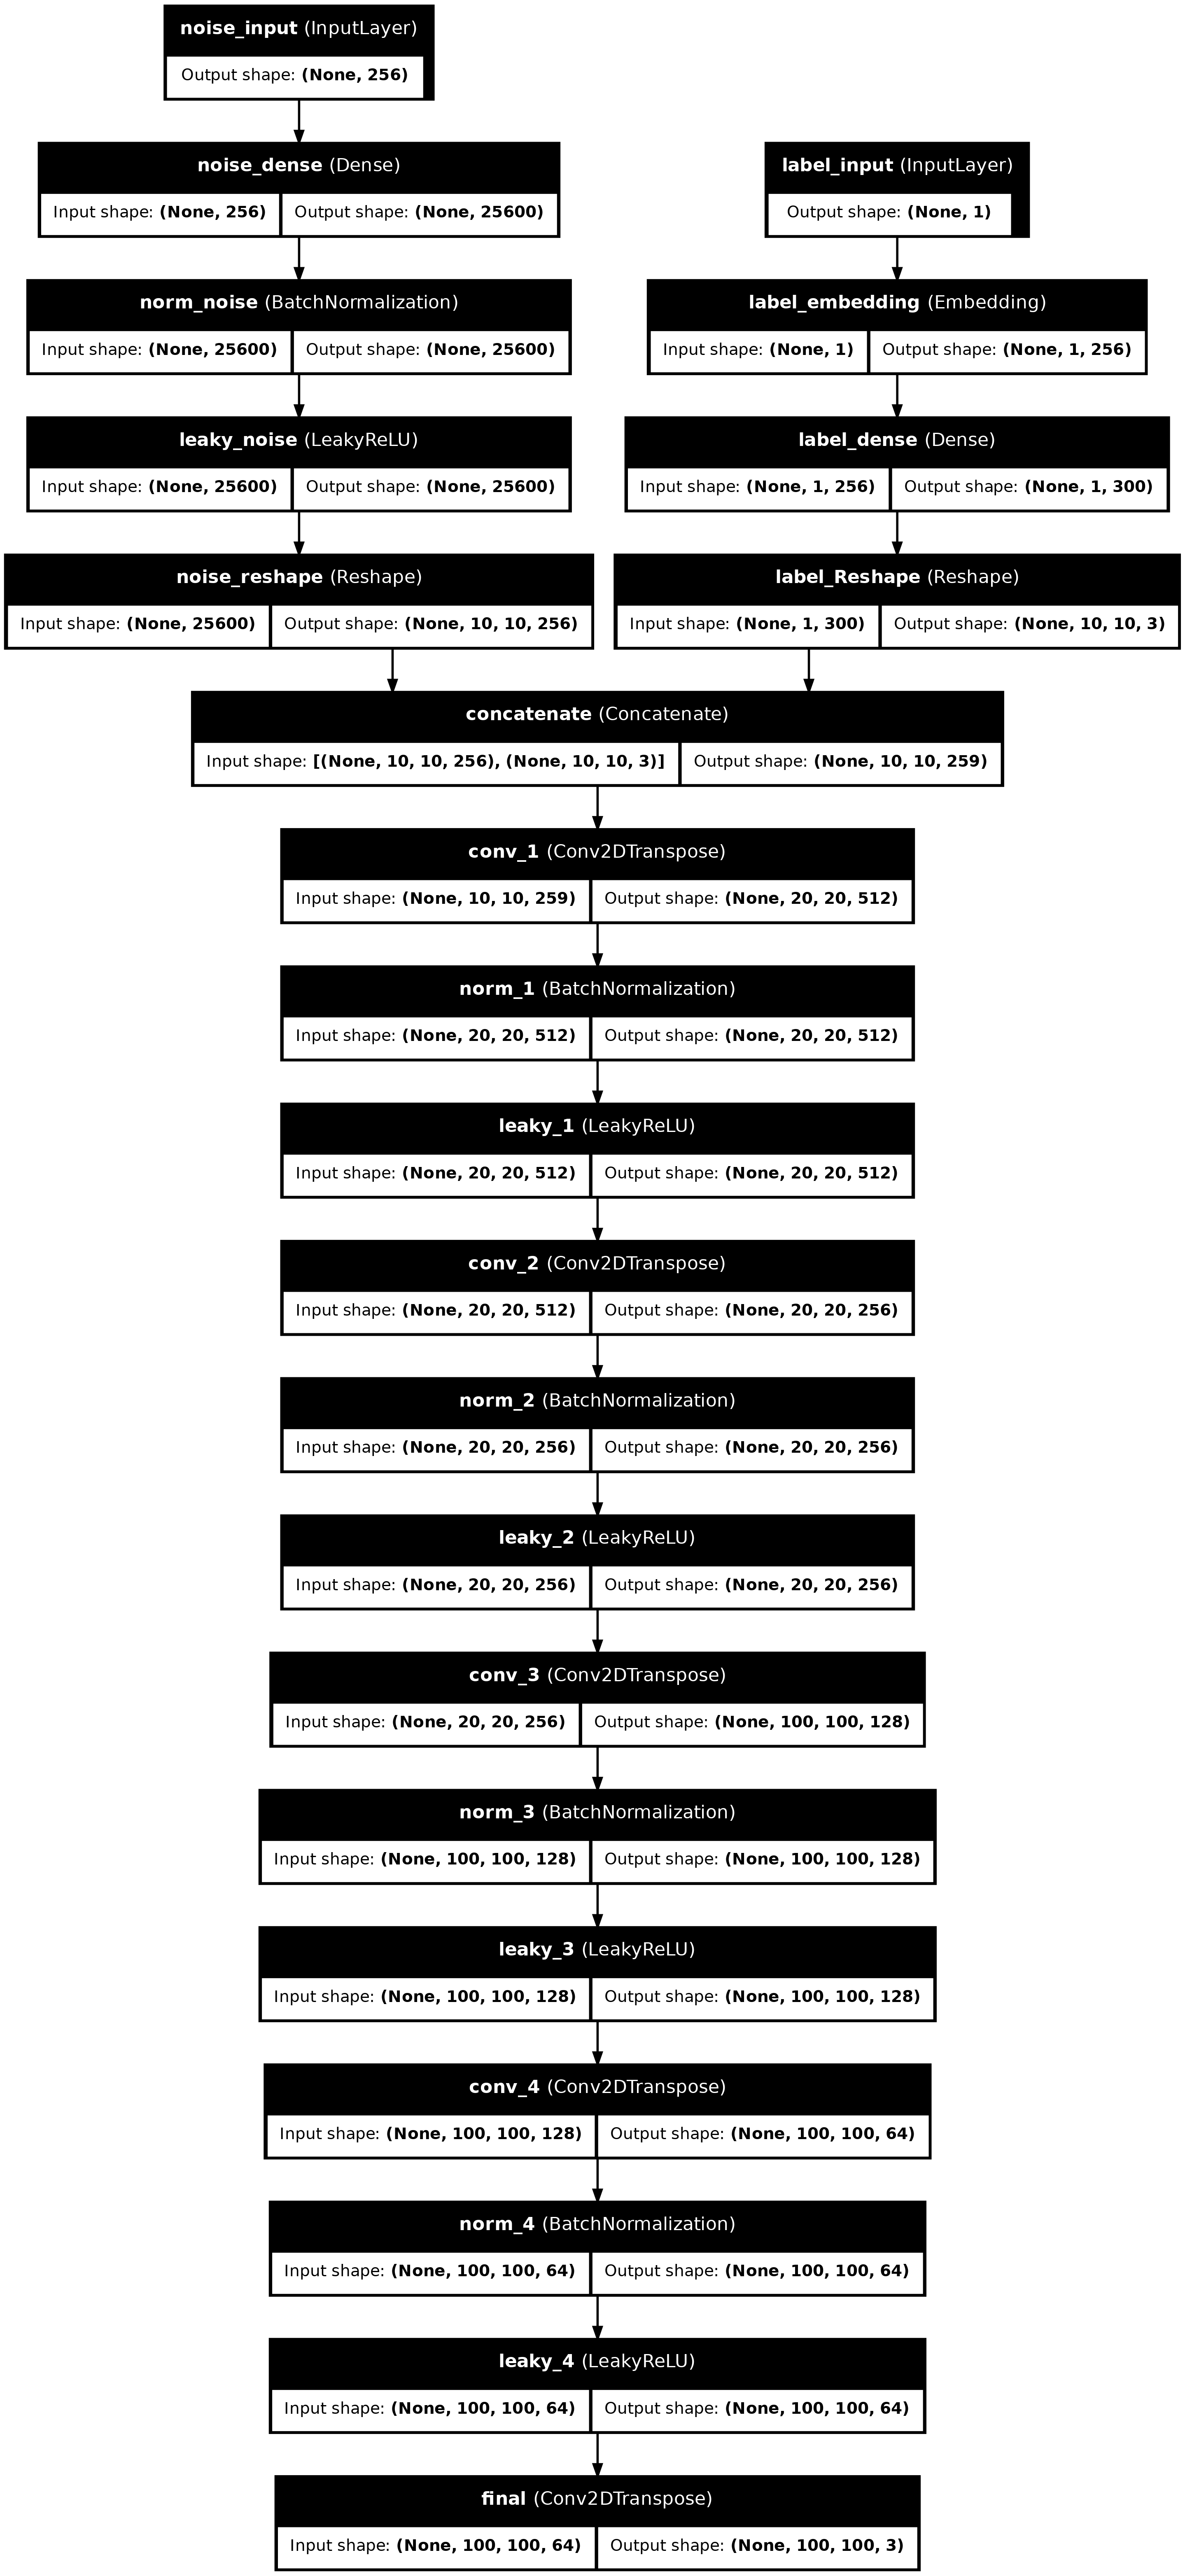

In [22]:
#display_model(make_generator_ac(no_of_class,noise_shape,latent_dim),'../model_arch/ac_gen')

In [12]:
class Discriminator(tf.keras.Model):
    def __init__(self, latent_dim:np.ndarray,noise_shape:int,img_shape:tuple[int]) -> None:
        super(Discriminator,self).__init__()
        self.latent_shape = latent_dim
        self.noise_shape = noise_shape
        self.img = img_shape
        self.discriminator = make_discriminator_ac(self.img,no_of_class)
        self.real_loss = tf.keras.metrics.Mean(name="real_loss")
        self.class_loss = tf.keras.metrics.Mean(name="class_loss")
        
    @property
    def metrics(self):
        return [self.real_loss,self.class_loss]
        
    def compile(self,dis_opt,class_loss_func,real_loss_func):
        super(Discriminator,self).compile()
        self.dis_opt = dis_opt
        self.class_loss_func = class_loss_func
        self.real_loss_func = real_loss_func
            
    def train_step(self,image):
        img, label = image
        label = tf.expand_dims(label,axis=-1)
        
        with tf.GradientTape() as disc_tape:
            class_, real = self.discriminator([img,label])
            class_loss = self.class_loss_func(label,class_)
            real_loss = self.real_loss_func(real)
            
            total_loss = class_loss + real_loss
        
        graident_total = disc_tape.gradient(total_loss,self.discriminator.trainable_weights)
            
        self.dis_opt.apply_gradients(zip(graident_total,self.discriminator.trainable_weights))

        self.real_loss.update_state(real_loss)
        self.class_loss.update_state(class_loss)
        
        return {m.name: m.result() for m in self.metrics}
    
    def save_model(self):        
        try:
            self.discriminator.save('../saved_weights/acgan/dis.keras')
            print('Saved the discriminator')
        except:
            print('Error saving the discriminator')
            
    def load_model(self):        
        try:
            self.discriminator.load_weights('../saved_weights/acgan/dis.keras')
            print('Loaded the discriminator')
            
        except:
            print('Error loading the discriminator')
                

In [23]:
class AC_GAN(tf.keras.Model):
    def __init__(self, latent_dim:np.ndarray,noise_shape:int,img_shape:tuple[int]) -> None:
        super(AC_GAN,self).__init__()
        self.latent_shape = latent_dim
        self.noise_shape = noise_shape
        self.img = img_shape
        self.generator = make_generator_ac(no_of_class,self.noise_shape,self.latent_shape)
        self.discriminator = make_discriminator_ac(self.img,no_of_class)
        self.gen_loss = tf.keras.metrics.Mean(name="generator_loss")
        self.real_loss = tf.keras.metrics.Mean(name="discriminator_real_loss")
        self.class_loss = tf.keras.metrics.Mean(name="discriminator_class_loss")
        
    @property
    def metrics(self):
        return [self.gen_loss,self.real_loss,self.class_loss]
    
    def compile(self,gen_opt,dis_opt,gen_loss_func,dis_real_loss_func,dis_class_loss_func):
        super(AC_GAN,self).compile()
        self.gen_opt = gen_opt
        self.dis_opt = dis_opt
        self.gen_loss_func = gen_loss_func
        self.dis_real_loss_func = dis_real_loss_func
        self.dis_class_loss_func = dis_class_loss_func
    
    def call(self,noise,label):
        gen_img = self.generator([noise,label],training=False)
        return gen_img
    
    @tf.function
    def train_step(self, image):
        img, label = image
        label = tf.expand_dims(label,axis=-1)
        noise = tf.random.normal([BATCH, self.noise_shape])
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated = self.generator([noise,label],training=True)
        
            predicted_class,real_class = self.discriminator([img,label],training=True)
            generated_fake_class,generated_real_class = self.discriminator([generated,label],training=True)
            
            gen_loss_ =  self.gen_loss_func(generated_real_class)
            dis_loss_real = self.dis_real_loss_func(real_class) + self.dis_real_loss_func(generated_fake_class)
            dis_loss_class = self.dis_class_loss_func(label,predicted_class) + self.dis_class_loss_func(label,generated_fake_class)
            
            dis_total_loss = dis_loss_class + dis_loss_real
            
        
        gradients_g = gen_tape.gradient(gen_loss_, self.generator.trainable_variables)
        gradients_d = disc_tape.gradient(dis_total_loss, self.discriminator.trainable_variables)
        
        self.gen_opt.apply_gradients(zip(gradients_g, self.generator.trainable_variables))
        self.dis_opt.apply_gradients(zip(gradients_d, self.discriminator.trainable_variables))
        
        self.gen_loss.update_state(gen_loss_)
        self.real_loss.update_state(dis_loss_real)
        self.class_loss.update_state(dis_loss_class)
                
        return {m.name: m.result() for m in self.metrics}
    
    def save_model(self):        
        try:
            self.discriminator.save('../saved_weights/acgan/dis.keras')
            print('Saved the discriminator')
        except:
            print('Error saving the discriminator')
            
        try:
            self.generator.save('../saved_weights/acgan/gen.keras')
            print('Saved the generator')
        except:
            print('Error saving the generator')
            
    def load_model(self):        
        try:
            self.discriminator.load_weights('../saved_weights/acgan/dis.keras')
            print('Loaded the discriminator')
            
        except:
            print('Error loading the discriminator')
            
        try:
            self.generator.load_weights('../saved_weights/acgan/gen.keras')
            print('Loaded the generator')
            
        except:
            print('Error loading the generator')

In [24]:
acgan = AC_GAN(latent_dim,noise_shape,IMG_SIZE)

dis_opt = Adam(learning_rate=0.0001)
gen_opt = Adam(learning_rate=0.0001)

binary_entropy = BinaryCrossentropy()
cross_entropy = SparseCategoricalCrossentropy()


def dis_real_loss(real):
    return binary_entropy(tf.ones_like(real), real)
    
def dis_class_loss(generated,real):
    return cross_entropy(generated,real)

def gen_loss(fake):
    return binary_entropy(tf.ones_like(fake), fake)

In [15]:
acgan.compile(gen_opt,dis_opt,gen_loss,dis_real_loss,dis_class_loss)

In [16]:
acgan.fit(train,epochs=10)

Epoch 1/10


/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
I0000 00:00:1727707678.123009    2581 service.cc:145] XLA service 0x7f5040003480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727707678.123367    2581 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-09-30 20:17:58.420696: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-30 20:17:59.226618: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 

655/656 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - discriminator_class_loss: 7.8296 - discriminator_real_loss: 0.6383 - generator_loss: 0.0600

2024-09-30 20:19:02.516985: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at xla_ops.cc:580 : INVALID_ARGUMENT: Cannot concatenate arrays that differ in dimensions other than the one being concatenated. Dimension 0 in both shapes must be equal (or compatible): f32[10,10,10,256] vs f32[2,10,10,3].
	 [[{{function_node __inference_train_step_14945}}{{node AC_Generator_1/concatenate_1/concat}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_15324[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
2024-09-30 20:19:02.517073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Cannot concatenate arrays that differ in dimensions other than the one being concatenated. Dimension 0 in both shapes must be equal (or compatible): f32[10,10,10,256] vs f32[2,10,10,3].
	 [[{{function_node __inference_train_step_14945}}{{node

InvalidArgumentError: Graph execution error:

Detected at node AC_Generator_1/concatenate_1/concat defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_1677/1904037080.py", line 1, in <module>

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/tmp/ipykernel_1677/84408126.py", line 36, in train_step

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/models/functional.py", line 175, in call

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/models/functional.py", line 556, in call

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/layers/merging/base_merge.py", line 226, in call

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/layers/merging/concatenate.py", line 101, in _merge_function

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/ops/numpy.py", line 1352, in concatenate

  File "/home/omnissiah/miniconda3/envs/test_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/numpy.py", line 880, in concatenate

Cannot concatenate arrays that differ in dimensions other than the one being concatenated. Dimension 0 in both shapes must be equal (or compatible): f32[10,10,10,256] vs f32[2,10,10,3].
	 [[{{node AC_Generator_1/concatenate_1/concat}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_15324[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_iterator_15703]

In [ ]:
discriminator.save_model()